# CellML Models for Human Cardiac Cross-bridge Modelling

This notebook runs CellML versions of the Musgrave et al. (2025) human atrial cross-bridge model. The models can be run in OpenCOR directly, but only in isometric mode. For non-diabetic and diabetic models, these basic simulations are run here, as well as work-loop simulations (which use different modes of the model).


## Getting set up

A general introduction to Jupyter notebooks with OpenCOR can be found here: https://models.physiomeproject.org/e/afd.
To use the OpenCOR+Python to run Jupyter notebooks (on Windows), you will need to have *Write* permission to the OpenCOR installation folder. This is generally not the case when using the installer, so grab the "ZIP file" version of OpenCOR from the [downloads page](https://opencor.ws/downloads/index.html). And then unzip that to somewhere that you have write permission.  
    
## Launching the JupyterNotebook

Once you are all set up, find the location of "jupyternotebook.bat" in your OpenCOR directory. Copy this path and then launch a JupyterNotebook instance by running the path in a Windows command prompt, from the directory where this `.ipynb` file (and its associated cellml/sedml files) is located. E.g.

    "C:\Users\username\Documents\AtrialModel_2025_Human> "C:\Program Files\OpenCOR\jupyternotebook.bat"
    
Once this is running, your default browser should pop up and display the root Jupyter page. From here you can launch the interactive version of this notebook!

In [ ]:
import opencor as opencor # module info available at https://opencor.ws/user/pythonSupport.html
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


## Base CellML code - isometric twitches

This first section just runs the CellML code presented using a basic sedML file - this is an isometric muscle simulation with a baseline parameters.

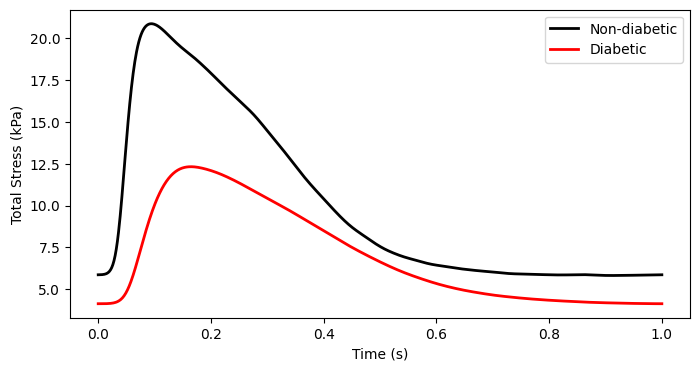

In [2]:

nd = opencor.open_simulation('musgrave_2025_nondiabetic.sedml') # both sedml files set up for one (1 s) twitch with 1 kHz sample rate
t2d = opencor.open_simulation('musgrave_2025_diabetic.sedml')

# reset and clear any existing results
nd.reset(True)
nd.clear_results()
t2d.reset(True)
t2d.clear_results()

# declare our results dictionaries
nd_data = {}
t2d_data = {}

# run twice to reach steady-state
nd.run()
nd.run()
t2d.run()
t2d.run()

ds = nd.results().data_store()
# Total Force(Stress)
nd_data['Ft'] = ds.voi_and_variables()['force_generation/Ft'].values()
# time
time=ds.voi().values()

ds = t2d.results().data_store()
t2d_data['Ft'] = ds.voi_and_variables()['force_generation/Ft'].values()

# figure plotting
plt.figure(figsize=(8,4))
plt.plot(time, nd_data['Ft'], label='Non-diabetic', color='black', linewidth=2)
plt.plot(time, t2d_data['Ft'], label='Diabetic', color='red', linewidth=2)
plt.legend()
plt.ylabel('Total Stress (kPa)')
plt.xlabel('Time (s)')
plt.show()
# close simulations
opencor.close_simulation(nd)
opencor.close_simulation(t2d)

## Work-loop simulations

The below functions allow us to run the work-loop simulations, by calling the different contraction modes (which are prescribed by separate cellml files)

In [3]:
# functions to streamline work-loop simulations

def simulate_mode(sim,start,step,stop,y0,i_0,F_after):
    ''' Runs a given simulation according to inputs, used to run each segment in the work-loop
    Arguments:
    sim (Simulation object): simulation to run
    start (int/float): starting time point
    step (int/float): step size for the simulation
    stop (int/float): final time point
    y0 (dict): values for each state as dictionary of DataStoreVariable objects (as found from sim.results().states())
    i_0 (int): index of y0 to use as start point for this simulation
    F_after (int/float): afterload value to prescribe
    Returns:
    sim.results() (Simulation Results object): complete results of the simulation
    '''
    sim.reset(True)
    sim.clear_results()
    sim_data=sim.data()
    sim_data.set_starting_point(start)
    sim_data.set_point_interval(step)
    sim_data.set_ending_point(stop)
    sim_data.constants()['length_control/F_after'] = F_after

    # update states
    for key in list(y0):
        sim_data.states()[key] = y0[key].values()[i_0]
    
    sim.run()

    return sim.results()

# function to append all simulation results to a dictionary for output
def store_results(all_vars, results, i_start, i_end):
    ''' Append all simulation results to a dictionary
    Arguments:
    all_vars (dict): dictionary containing arrays of each variable in the model to append to
    results (SimulationResults object): complete results of the simulation
    i_start (int): first index of results to append
    i_end (int): final index of results to append
    Returns:
    all_vars (dict): input dictionary with new results appended
    Notes:
    all_vars uses keys that ignore the component name (i.e. just use the variable name)
    '''
    vars = results.data_store().variables()
    for key in list(vars):
        new_key = key[key.find('/')+1:]
        all_vars[new_key] = np.hstack((all_vars[new_key],vars[key].values()[i_start:i_end]))
    return all_vars


def simulate_work_loop(F_after,model_name):
    ''' Runs a full work-loop simulation for a given afterload
    Arguments:
    F_after (int/float): afterload value for the work-loop
    model_name (string): 'diabetic' or 'nondiabetic'
    Returns:
    time (list): array of all time points in the simulation
    all_vars (dict): dictionary containing arrays of each variable in the model at all time points in the simulation
    Notes:
    all_vars uses keys that ignore the component name (i.e. just use the variable name)
    '''
    isomet = opencor.open_simulation(f'musgrave_2025_{model_name}.cellml')
    isoton = opencor.open_simulation(f'musgrave_2025_{model_name}_isoton.cellml')
    restretch1 = opencor.open_simulation(f'musgrave_2025_{model_name}_RS1.cellml')
    restretch2 = opencor.open_simulation(f'musgrave_2025_{model_name}_RS2.cellml')

    time = []
    all_vars = {}    
    for key in list(isomet.results().data_store().variables()):
        new_key = key[key.find('/')+1:]
        all_vars[new_key] = []
    dt = 0.001

    ### phase 1: isometric ### (run whole twitch for steady-state + 0.2 s)
    results = simulate_mode(isomet,0,dt,1.2,[],-1,F_after)
    # ignore first twitch
    IM_Ft = results.algebraic()['force_generation/Ft'].values()[1000:]
    IM_t = results.voi().values()[1000:]-1
    
    i_max = np.argmax(IM_Ft)
    # search for point closest to F_after, before peak
    i_switch = np.argmin(np.abs(IM_Ft[:i_max]-F_after))
    t_switch = IM_t[i_switch] # match index to time
    time = np.hstack((time,IM_t[:i_switch]))
    all_vars = store_results(all_vars, results, 1000, i_switch + 1000)

    ### phase 2: isotonic ###
    results = simulate_mode(isoton,t_switch,dt,t_switch + 0.2,results.states(),i_switch,F_after)
    IT_L = results.states()['length_control/L'].values()
    i_switch = np.argmin(IT_L)
    t_switch = results.voi().value(i_switch)
    time = np.hstack((time,results.voi().values()[0:i_switch]))
    all_vars = store_results(all_vars, results, 0, i_switch)

    ### phase 3: isometric ###
    results=simulate_mode(isomet,t_switch,dt,0.8,results.states(),i_switch,F_after)
    time = np.hstack((time,results.voi().values()[:-1]))
    all_vars = store_results(all_vars, results, 0, -1)

    ### phase 4: restretch 1 (gradual) ###
    results=simulate_mode(restretch1,0.8,dt,0.85,results.states(),-1,F_after)
    time = np.hstack((time,results.voi().values()[:-1]))
    all_vars = store_results(all_vars, results, 0, -1)
    
    ### phase 5: restretch 2 (faster) ###
    results=simulate_mode(restretch2,0.85,dt,0.95,results.states(),-1,F_after)
    time = np.hstack((time,results.voi().values()[:-1]))
    all_vars = store_results(all_vars, results, 0, -1)

    ### phase 6: isometric relax ###
    results=simulate_mode(isomet,0.95,dt,1,results.states(),-1,F_after)
    time = np.hstack((time,results.voi().values()))
    all_vars = store_results(all_vars, results, 0, None)

    #replace arrays with constants for any true constants
    for key in list(isomet.data().constants()):
        new_key = key[key.find('/')+1:]
        if max(all_vars[new_key]-all_vars[new_key][0]) == 0:
            all_vars[new_key] = isomet.data().constants()[key]

    opencor.close_simulation(isomet)
    opencor.close_simulation(isoton)
    opencor.close_simulation(restretch1)
    opencor.close_simulation(restretch2)

    return time, all_vars


def analyse_workloops(all_vars,time):
    ''' Finds output metrics of work-loop simulations
    Arguments:
    time (list): array of all time points in the simulation
    all_vars (dict): dictionary containing arrays of each variable in the model at all time points in the simulation
    Returns:
    work (float): work produced during the work-loop (kJ/m^3)
    shortening (float): percentage of shortening obtained during the work-loop
    velocity (float): maximum velocity of shortening during the work-loop (muscle lengths per second)
    power(float): maximum power of shortening during the work-loop (kW/m^3)
    energy (float): energy consumed by cross-bridges during the work-loop (kJ/m^3)
    efficiency (float): efficiency of the work-loop (%)
    '''

    #print(f'numpy version: v{np.version.version}')
    # required vars/constants
    Ft = all_vars['Ft']
    L = all_vars['L']
    L0 = all_vars['L0']
    #dL = all_vars['L/prime']
    k3 = all_vars['k3']
    C = all_vars['C']
    k_3 = all_vars['k_3']
    A = all_vars['A']
    M_frac = all_vars['rho_myo']
    G_ATP = all_vars['G_ATP']
    F_after = all_vars['F_after']

    work = np.abs(np.trapz(Ft, x= L/L0,))  #note this is trapezium in newer versions of numpy
    shortening = 100 - min(L)/L0*100
    velocity = -min(np.gradient(L/L0,0.001)) #max slope of L is better estimator than dL (esp due to noise)
    power = F_after * velocity
    
    ATPase_rate=(k3*C-k_3*A)*0.25*M_frac
    energy = np.abs(np.trapz(ATPase_rate, x=time))*-G_ATP
    efficiency = work/energy*100
    return work, shortening, velocity, power, energy, efficiency


#### The section below runs a single (one afterload) work-loop simulation for a model of choice

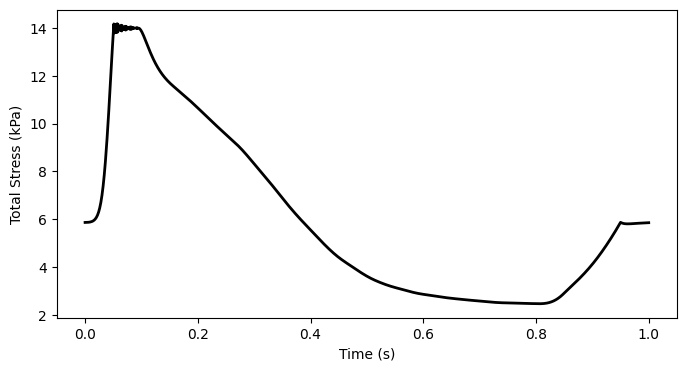

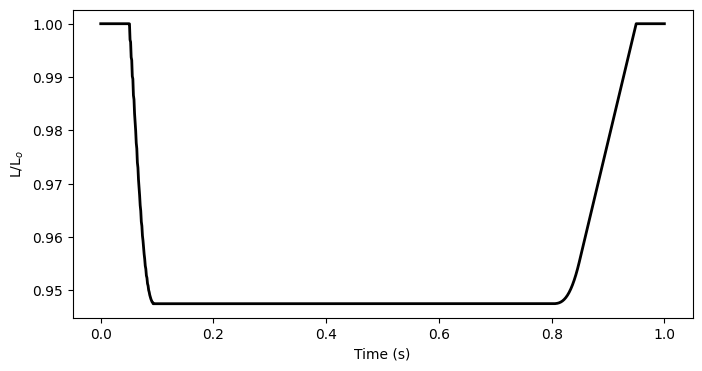

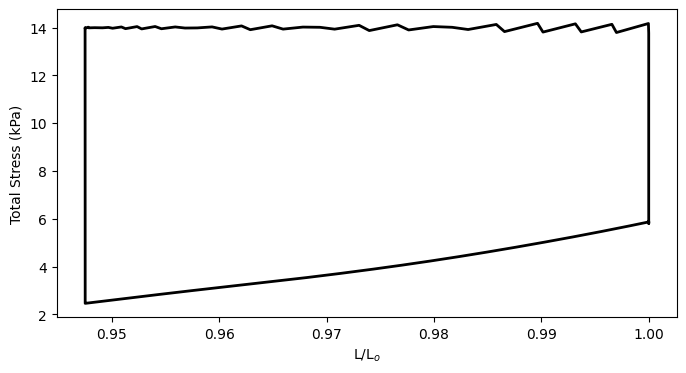

work=0.526 kJ/m^3, shortening=5.2%, velocity=2.056 s^-1, power=28.780 kW/m^3,energy=18.467 kJ/m^3, efficiency=2.8%



In [4]:
# Runs a single work-loop
model_name = 'nondiabetic' # or 'diabetic'

time, all_vars= simulate_work_loop(14,model_name)

plt.figure(figsize=(8,4))
plt.plot(time, all_vars['Ft'], color='black', linewidth=2)
plt.ylabel('Total Stress (kPa)')
plt.xlabel('Time (s)')
plt.figure(figsize=(8,4))
plt.plot(time, all_vars['L']/2.2, color='black', linewidth=2)
plt.ylabel('L/L$_o$')
plt.xlabel('Time (s)')
plt.figure(figsize=(8,4))
plt.plot(all_vars['L']/2.2, all_vars['Ft'], color='black', linewidth=2)
plt.ylabel('Total Stress (kPa)')
plt.xlabel('L/L$_o$')
plt.show()

work, shortening, velocity, power, energy, efficiency = analyse_workloops(all_vars, time)
print(f'work={work:.3f} kJ/m^3, shortening={shortening:.1f}%, velocity={velocity:.3f} s^-1, power={power:.3f} kW/m^3,' 
    f'energy={energy:.3f} kJ/m^3, efficiency={efficiency:.1f}%\n')

#### The section below runs 'full' work-loop simulations, as in the original paper - this involves 10 work-loops for each model

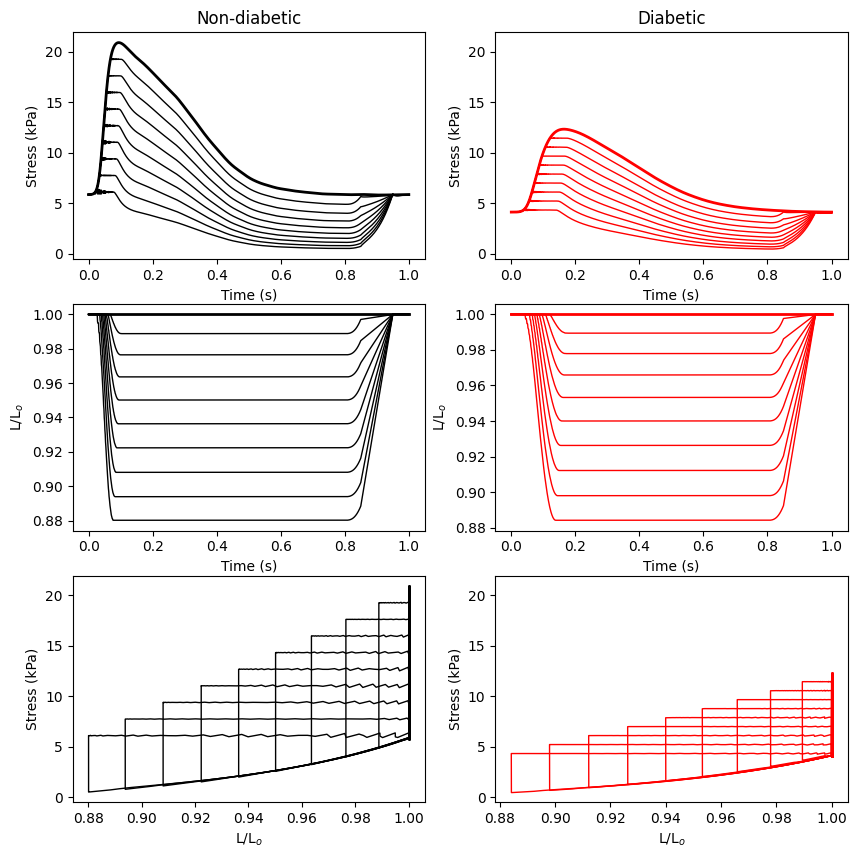

In [5]:
# Runs the range of 10 work-loops for each model (same as in the original paper)
fig, ax = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(10,10)

model_name = 'nondiabetic'
nd_work = np.zeros(10)
nd_short = np.zeros(10)
nd_vel = np.zeros(10)
nd_pow = np.zeros(10)
nd_energy = np.zeros(10)
nd_eff = np.zeros(10)

isomet = opencor.open_simulation(f'musgrave_2025_{model_name}.cellml')
all_vars = {}
results = simulate_mode(isomet,0,0.001,2,[],0,0)
vars = results.data_store().variables()
for key in list(vars):
    new_key = key[key.find('/')+1:]
    if key not in list(isomet.data().constants()):
        all_vars[new_key] = vars[key].values()[1000:]
    else:
        all_vars[new_key] = isomet.data().constants()[key]
nd_Ftwitch = all_vars['Ft']
time = results.voi().values()[1000:]-1
all = analyse_workloops(all_vars, time)
nd_work[9], nd_short[9], nd_vel[9], nd_pow[9], nd_energy[9], nd_eff[9] = analyse_workloops(all_vars, time)
ax[0,0].plot(time, nd_Ftwitch, color='black', linewidth=2)
ax[1,0].plot(time, all_vars['L']/all_vars['L0'], color='black', linewidth=2)
ax[2,0].plot(all_vars['L']/all_vars['L0'], nd_Ftwitch, color='black', linewidth=2)
opencor.close_simulation(isomet)

nd_afterloads = np.linspace((min(nd_Ftwitch)*1.05),max(nd_Ftwitch),10)

for i in range(9):
    a = nd_afterloads[i]
    time, all_vars = simulate_work_loop(a,model_name)
    ax[0,0].plot(time, all_vars['Ft'], color='black', linewidth=1)
    ax[1,0].plot(time, all_vars['L']/all_vars['L0'], color='black', linewidth=1)
    ax[2,0].plot(all_vars['L']/all_vars['L0'], all_vars['Ft'], color='black', linewidth=1)
    nd_work[i], nd_short[i], nd_vel[i], nd_pow[i], nd_energy[i], nd_eff[i] = analyse_workloops(all_vars, time)


model_name = 'diabetic'
d_work = np.zeros(10)
d_short = np.zeros(10)
d_vel = np.zeros(10)
d_pow = np.zeros(10)
d_energy = np.zeros(10)
d_eff = np.zeros(10)

isomet = opencor.open_simulation(f'musgrave_2025_{model_name}.cellml')
all_vars = {}
results = simulate_mode(isomet,0,0.001,2,[],0,0)
vars = results.data_store().variables()
for key in list(vars):
    new_key = key[key.find('/')+1:]
    if key not in list(isomet.data().constants()):
        all_vars[new_key] = vars[key].values()[1000:]
    else:
        all_vars[new_key] = isomet.data().constants()[key]
d_Ftwitch = all_vars['Ft']
time = results.voi().values()[1000:]-1
d_work[9], d_short[9], d_vel[9], d_pow[9], d_energy[9], d_eff[9] = analyse_workloops(all_vars, time)
ax[0,1].plot(time, d_Ftwitch, color='red', linewidth=2)
ax[1,1].plot(time, all_vars['L']/all_vars['L0'], color='red', linewidth=2)
ax[2,1].plot(all_vars['L']/all_vars['L0'], d_Ftwitch, color='red', linewidth=2)
opencor.close_simulation(isomet)

d_afterloads = np.linspace((min(d_Ftwitch)*1.05),max(d_Ftwitch),10)
for i in range(9):
    a = d_afterloads[i]
    time, all_vars = simulate_work_loop(a,model_name)
    ax[0,1].plot(time, all_vars['Ft'], color='red', linewidth=1)
    ax[1,1].plot(time, all_vars['L']/all_vars['L0'], color='red', linewidth=1)
    ax[2,1].plot(all_vars['L']/all_vars['L0'], all_vars['Ft'], color='red', linewidth=1)
    d_work[i], d_short[i], d_vel[i], d_pow[i], d_energy[i], d_eff[i] = analyse_workloops(all_vars, time)
    

ax[0,0].set_title('Non-diabetic')
ax[0,1].set_title('Diabetic')
ax[0,1].set_ylim(ax[0,0].get_ylim())
ax[2,1].set_ylim(ax[2,0].get_ylim())
for i in range(2):
    ax[0,i].set_ylabel('Stress (kPa)')
    ax[0,i].set_xlabel('Time (s)')
    ax[1,i].set_ylabel('L/L$_o$')
    ax[1,i].set_xlabel('Time (s)')
    ax[2,i].set_ylabel('Stress (kPa)')
    ax[2,i].set_xlabel('L/L$_o$')
plt.show()

#### The section below plots the work-loop metrics calculated in the simulation above

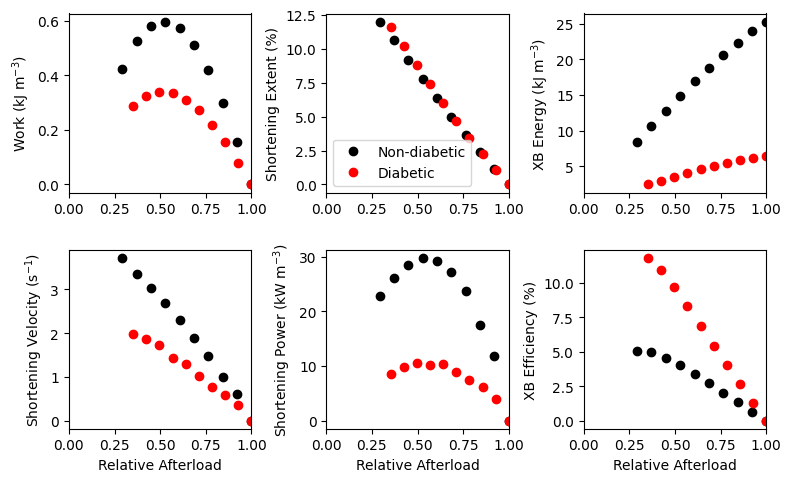

In [6]:
# separate plotting for the work-loop metrics calculated in above simulation
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(8,5)
plt.tight_layout(pad=2)
#work
ax[0,0].plot(nd_afterloads/nd_afterloads[9], nd_work, 'o', color='black')
ax[0,0].plot(d_afterloads/d_afterloads[9], d_work, 'o', color='red')
ax[0,0].set_ylabel('Work (kJ m$^{-3}$)')
ax[0,0].set_xlim(0, 1)
# shortening
ax[0,1].plot(nd_afterloads/nd_afterloads[9], nd_short, 'o', color='black')
ax[0,1].plot(d_afterloads/d_afterloads[9], d_short, 'o', color='red')
ax[0,1].set_ylabel('Shortening Extent (%)')
ax[0,1].set_xlim(0, 1)
ax[0,1].legend(['Non-diabetic', 'Diabetic'])
# velocity
ax[1,0].plot(nd_afterloads/nd_afterloads[9], nd_vel, 'o', color='black')
ax[1,0].plot(d_afterloads/d_afterloads[9], d_vel, 'o', color='red')
ax[1,0].set_ylabel('Shortening Velocity (s$^{-1}$)')
ax[1,0].set_xlabel('Relative Afterload')
ax[1,0].set_xlim(0, 1)
# power
ax[1,1].plot(nd_afterloads/nd_afterloads[9], nd_pow, 'o', color='black')
ax[1,1].plot(d_afterloads/d_afterloads[9], d_pow, 'o', color='red')
ax[1,1].set_ylabel('Shortening Power (kW m$^{-3}$)')
ax[1,1].set_xlabel('Relative Afterload')
ax[1,1].set_xlim(0, 1)
# energy
ax[0,2].plot(nd_afterloads/nd_afterloads[9], nd_energy, 'o', color='black')
ax[0,2].plot(d_afterloads/d_afterloads[9], d_energy, 'o', color='red')
ax[0,2].set_ylabel('XB Energy (kJ m$^{-3}$)')
ax[0,2].set_xlim(0, 1)
# efficiency
ax[1,2].plot(nd_afterloads/nd_afterloads[9], nd_eff, 'o', color='black')
ax[1,2].plot(d_afterloads/d_afterloads[9], d_eff, 'o', color='red')
ax[1,2].set_ylabel('XB Efficiency (%)')
ax[1,2].set_xlabel('Relative Afterload')
ax[1,2].set_xlim(0, 1)
plt.show()



### Notes for other simulations:
'force_generation/rho_myo' can be changed to 1 in order to simulate force production at the myocyte level, rather than the muscle level.

'model_parameters/ATP' and 'model_parameters/Pi' can be changed to explore the effects of changing metabolite conditions.

For the work-loop simulations, changes to parameters must be performed within the 'simulate_mode' function. These are all constants in the model, so can be changed programatically the same way as F_after.

https://opencor.ws/user/pythonSupport.html explains how to access the different data types produced in an OpenCOR simulation.